# Flappy Bird — Dueling Double DQN (State-Based, Gymnasium)
This notebook implements a **state-based** Dueling Double DQN for `FlappyBird-v0` from **flappy-bird-gymnasium**.
It includes:
- Dueling DQN network architecture
- Double DQN training logic
- Replay buffer with `push()` and `sample()`
- Reward shaping and survival/progress bonuses
- Slower epsilon decay
- Gradient clipping and step-based target updates
- Model saving/loading and optional gameplay recording


In [24]:
#pip install gymnasium flappy-bird-gymnasium torch numpy matplotlib imageio[ffmpeg] tqdm --quiet
#pip install moviepy


In [25]:
import random
import os
import math
import time
import numpy as np
import gymnasium as gym
import flappy_bird_gymnasium
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import imageio
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


In [26]:
# Dueling DQN (state-based)
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=128):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.value_head = nn.Linear(hidden, 1)
        self.adv_head = nn.Linear(hidden, action_size)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device)
        x = x.float().to(device)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        value = self.value_head(h)
        adv = self.adv_head(h)
        q = value + (adv - adv.mean(dim=1, keepdim=True))
        return q


In [27]:
# Replay buffer
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.asarray(states, dtype=np.float32)
        next_states = np.asarray(next_states, dtype=np.float32)
        return (
            torch.from_numpy(states).to(device),
            torch.tensor(actions, dtype=torch.long, device=device),
            torch.tensor(rewards, dtype=torch.float32, device=device),
            torch.from_numpy(next_states).to(device),
            torch.tensor(dones, dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)


In [28]:
# Utilities: stacking, action selection, save/load
def stack_frames(buffer_deque, new_state, k):
    if len(buffer_deque) == 0:
        for _ in range(k):
            buffer_deque.append(new_state)
    else:
        buffer_deque.append(new_state)
    return np.concatenate(list(buffer_deque), axis=-1)

def select_action(q_net, state, action_space, epsilon):
    if random.random() < epsilon:
        return action_space.sample()
    state_t = torch.from_numpy(np.array(state, dtype=np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        qvals = q_net(state_t)
        return int(torch.argmax(qvals, dim=1).item())

def save_model(net, path):
    torch.save(net.state_dict(), path)

def load_model(net, path):
    net.load_state_dict(torch.load(path, map_location=device))


In [29]:

# Training function (Dueling DQN only, state-based)
def train_dueling_dqn_state(
    env_name='FlappyBird-v0',
    episodes=2000,
    gamma=0.99,
    lr=5e-5,
    batch_size=128,
    memory_size=100000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9998,  
    target_update_steps=4000, 
    reward_scale=5.0,
    survival_bonus=0.02,
    progress_coef=0.001,
    grad_clip=10.0,
    frame_stack_k=3,
    save_path='best_flappy_dueling_dqn_state.pth',
    record_video=False,
    video_path='flappy_state_trained.mp4'
):
    env = gym.make(env_name)
    obs, _ = env.reset()
    base_dim = len(obs)
    state_dim = base_dim * frame_stack_k
    action_dim = env.action_space.n

    q_net = DuelingDQN(state_dim, action_dim).to(device)
    target_net = DuelingDQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    memory = ReplayBuffer(memory_size)

    epsilon = epsilon_start
    train_steps = 0
    rewards_history = []
    best_avg = -1e9
    moving_avg_window = 100

    for ep in range(1, episodes+1):
        obs, _ = env.reset()
        frame_deque = deque(maxlen=frame_stack_k)
        state = stack_frames(frame_deque, obs, frame_stack_k)
        total_reward = 0.0
        done = False

        prev_h_dist = None
        while not done:
            action = select_action(q_net, state, env.action_space, epsilon)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            env_r = float(reward)
            try:
                h_dist = float(next_obs[2])
            except Exception:
                h_dist = None

            progress_bonus = 0.0
            if prev_h_dist is not None and h_dist is not None:
                progress_bonus = progress_coef * max(0.0, prev_h_dist - h_dist)
            prev_h_dist = h_dist if h_dist is not None else prev_h_dist

            shaped = env_r * reward_scale + survival_bonus + progress_bonus
            shaped = float(max(-2.0, min(2.0, shaped)))

            frame_deque.append(next_obs)
            next_state = np.concatenate(list(frame_deque), axis=-1)

            memory.push(state, action, shaped, next_state, float(done))
            state = next_state
            total_reward += env_r

            if len(memory) >= batch_size:
                states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)

                q_values = q_net(states_b).gather(1, actions_b.unsqueeze(1)).squeeze(1)

                # Standard DQN update (no double)
                with torch.no_grad():
                    next_q = target_net(next_states_b).max(1)[0]
                    target_q = rewards_b + gamma * next_q * (1.0 - dones_b)

                loss = F.mse_loss(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), grad_clip)
                optimizer.step()

                train_steps += 1
                if train_steps % target_update_steps == 0:
                    target_net.load_state_dict(q_net.state_dict())

            epsilon = max(epsilon_end, epsilon * epsilon_decay)

        rewards_history.append(total_reward)
        avg_recent = float(np.mean(rewards_history[-moving_avg_window:])) if len(rewards_history) >= moving_avg_window else float(np.mean(rewards_history))
        if len(rewards_history) >= moving_avg_window and avg_recent > best_avg:
            best_avg = avg_recent
            save_model(q_net, save_path)

        if ep % 10 == 0 or ep == 1:
            print(f"Episode {ep}/{episodes} | Reward: {total_reward:.2f} | Avg{moving_avg_window}: {avg_recent:.2f} | Epsilon: {epsilon:.4f} | Buffer: {len(memory)}")

    env.close()
    return q_net, rewards_history


In [30]:

model, rewards = train_dueling_double_dqn_state(
    env_name='FlappyBird-v0',
    episodes=10000,       
    gamma=0.99,
    lr=5e-5,
    batch_size=128,
    memory_size=100000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9998,
    target_update_steps=4000,
    reward_scale=5.0,
    survival_bonus=0.02,
    progress_coef=0.001,
    grad_clip=10.0,
    frame_stack_k=3,
    save_path='best_flappy_dqn_state.pth',
    record_video=True,
    video_path='flappy_state_trained.mp4'
)


Episode 1/10000 | Reward: -6.90 | Avg100: -6.90 | Epsilon: 0.9900 | Buffer: 50
Episode 10/10000 | Reward: -7.50 | Avg100: -7.20 | Epsilon: 0.9048 | Buffer: 500
Episode 20/10000 | Reward: -8.10 | Avg100: -7.35 | Epsilon: 0.8187 | Buffer: 1000
Episode 30/10000 | Reward: -8.10 | Avg100: -7.22 | Epsilon: 0.7408 | Buffer: 1500
Episode 40/10000 | Reward: -7.50 | Avg100: -6.99 | Epsilon: 0.6703 | Buffer: 2000
Episode 50/10000 | Reward: -6.30 | Avg100: -6.89 | Epsilon: 0.6065 | Buffer: 2500
Episode 60/10000 | Reward: -5.70 | Avg100: -6.65 | Epsilon: 0.5488 | Buffer: 3000
Episode 70/10000 | Reward: -4.50 | Avg100: -6.59 | Epsilon: 0.4966 | Buffer: 3500
Episode 80/10000 | Reward: -6.90 | Avg100: -6.55 | Epsilon: 0.4493 | Buffer: 4000
Episode 90/10000 | Reward: -4.50 | Avg100: -6.38 | Epsilon: 0.4065 | Buffer: 4500
Episode 100/10000 | Reward: -0.90 | Avg100: -6.07 | Epsilon: 0.3678 | Buffer: 5000
Episode 110/10000 | Reward: -0.90 | Avg100: -5.81 | Epsilon: 0.3328 | Buffer: 5500
Episode 120/10000 

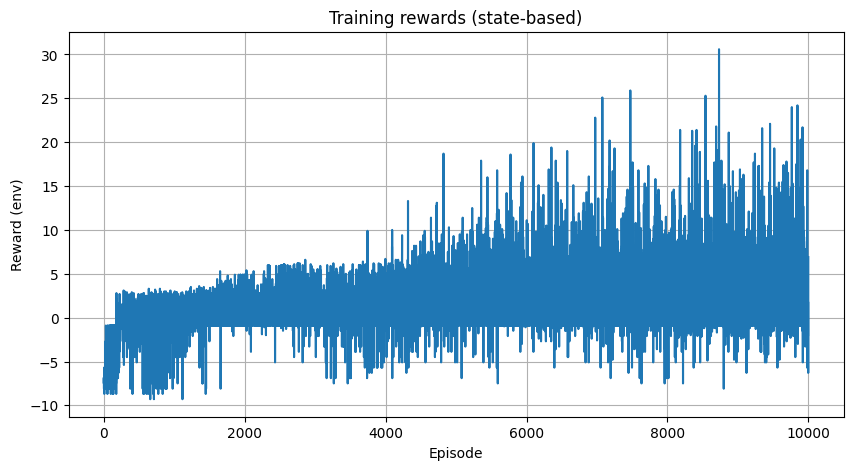

In [31]:
# Plot rewards
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward (env)')
plt.title('Training rewards (state-based)')
plt.grid(True)
plt.show()


NameError: name 'env' is not defined